## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
#!pip install -r requirements.txt

  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2.2.3


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [54]:
Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Tanzania_Data = '1tlNUxe2hY2DAOsv6u7R7yC_CiBcr05cXXQiRWBlEHEo'
Senegal_Data = '1cCszXB2Irc1Dp9zyIQgeu4OVWy9ZqvJbTielK8h9PLk'
Mali_Data = '1FnbKj5gwoAQb0QSunBQmyExHwaiLEAdAFCxL59SWLyg'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [52]:
def load_country_data(sheet_key):

    sheet_names = {
        "expenditures": "Food Expenditures (2019-20)",
        "prices": "Food Prices (2019-20)",
        "household": "Household Characteristics"
    }

    # Read expenditures
    x = read_sheets(sheet_key, sheet=sheet_names["expenditures"])
    x = x.set_index(['i','t','m','j']).squeeze()

    # Read prices
    p = read_sheets(sheet_key, sheet=sheet_names["prices"]).set_index(['t','m','j','u'])
    p = p.groupby(['t','m','j','u']).median()  # Median price
    #p.index = p.index.set_levels(p.index.levels[-1].str.lower(), level='u')

    p = p.xs('kg', level='u').squeeze().unstack('j')  # Just kg prices
    p = p[x.index.levels[-1]].T  # Keep only goods in expenditures

    # Read household characteristics
    d = read_sheets(sheet_key, sheet=sheet_names["household"])
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)  # Fill blanks with zero

    # Process expenditures
    x = x.T.groupby(['i','t','m','j']).sum()
    x = x.replace(0, np.nan)  # Replace zero with missing
    y = np.log(x)  # Take logs

    d.set_index(['i','t','m'], inplace=True)

    return x, y, p, d


In [55]:
#x_uganda, y_uganda, p_uganda, d_uganda = load_country_data(Uganda_Data)
x_tanzania, y_tanzania, p_tanzania, d_tanzania = load_country_data(Tanzania_Data)
#x_mali, y_mali, p_mali, d_mali = load_country_data(Mali_Data)
x_senegal, y_senegal, p_senegal, d_senegal = load_country_data(Senegal_Data)

KeyError: '[\'Ananas\', \'Arôme (Maggi, Jumbo, etc.)\', \'Autres huiles n.d.a. (maïs, huile palmiste, etc.)\', \'Autres tisanes et infusions n.d.a. (quinquelibat, citronelle, etc.)\', \'Biscuits\', \'Bières et vins traditionnels (soum soum, sung, vin de palme, vin de raphia, etc.)\', \'Bières industrielles\', \'Boissons gazeuses (coca, etc.)\', \'Charcuterie (jambon, saucisson), conserves de viandes\', \'Chocolat en poudre\', \'Chocolat à croquer, pâte à tartiner\', \'Conserves de poisson\', \'Cube alimentaire (Maggi, Jumbo, )\', \'Eau minérale/ filtrée\', \'Feuilles de manioc, feuilles de taro et autres feuilles\', \'Feuilles de nébéday (moringa)\', \'Gari, tapioca\', "Huile d\'arachide raffinée", \'Huile d____arachide "ségal"\', \'Huile de coton\', \'Huile de palme raffinée\', \'Huile de palme rouge\', \'Huile de soja / végétale (e.g., Ninaal, Jaara, etc.)\', \'Jus de fruits (orange, bissap, gingembre, jus de cajou,etc.)\', \'Jus en poudre\', \'Lait caillé, yaourt\', \'Lait concentré non-sucré\', \'Lait concentré sucré\', \'Lait et farines pour bébé\', \'Lait frais\', \'Mayonnaise\', \'Maïs en épi\', \'Noix de cajou\', \'Noix de coco\', \'Oeufs\', \'Pain moderne\', \'Pain traditionnel\', \'Petits pois conserve\', \'Poulet sur pied\', \'Salade (laitue, batavia, etc.)\'] not in index'

This gives a dataframe of household characteristics $d$ with a simple structure.



In [4]:
d_uganda.head()

,,k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.609438
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.098612
00246782f8654441a9df0f6ec0b6fc9f,2019-20,Northern,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.791759
003ed8d32f794609919d60d2ed8813e8,2019-20,Eastern,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.386294
004e93d7552248ed95d8bc3ec21bdbdb,2018-19,Eastern,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.386294


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
y.head()

i                                 t        m         j              
0007d1f1449242feb5a25429644fb991  2019-20  Northern  Beans (dry)         9.392662
                                                     Beef               10.239960
                                                     Beer                9.169518
                                                     Cabbage (green)     6.907755
                                                     Cassava (fresh)     8.294050
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [7]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [8]:
result.predicted_expenditures()

i                                 t        m         j                     
0007d1f1449242feb5a25429644fb991  2019-20  Northern  Avocado                    1836.603231
                                                     Beans (dry)                8530.391173
                                                     Beans (fresh)              4828.283261
                                                     Beef                      15788.755164
                                                     Bogoya                     4770.257706
                                                                                   ...     
ffec87c6ae87498f956723afe69266b9  2019-20  Eastern   Sweet Potatoes (fresh)     8625.903421
                                                     Tea (leaves)                218.108367
                                                     Tomatoes                   1543.016198
                                                     Waragi                     4677.821554
    

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

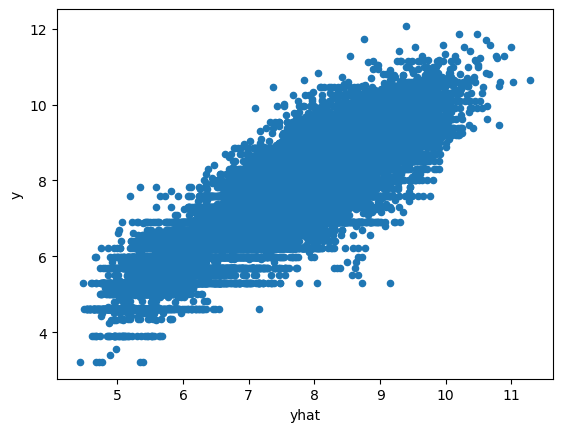

In [9]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



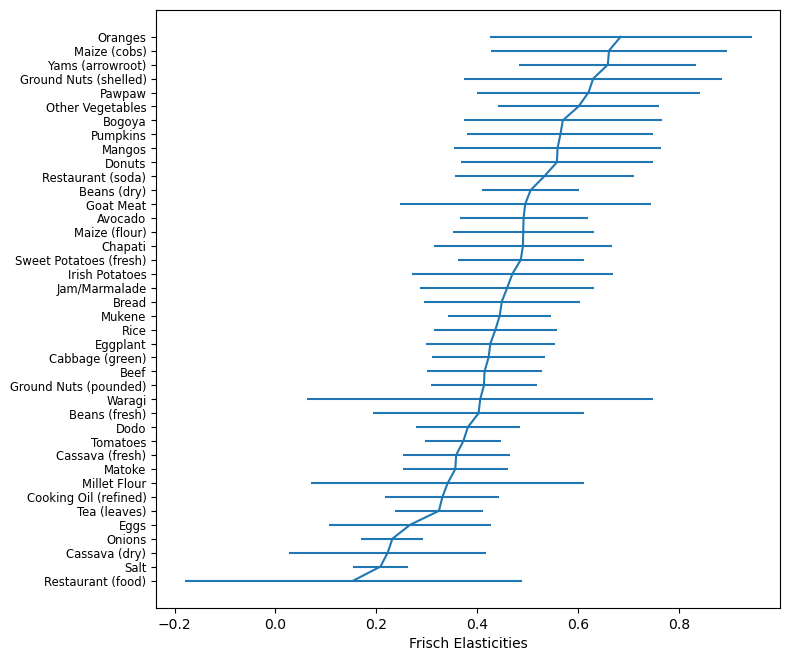

In [10]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [11]:
result.get_beta()

j
Avocado                   0.491605
Beans (dry)               0.505585
Beans (fresh)             0.402485
Beef                      0.414268
Bogoya                    0.569319
Bread                     0.448379
Cabbage (green)           0.422295
Cassava (dry)             0.222406
Cassava (fresh)           0.358005
Chapati                   0.490357
Cooking Oil (refined)     0.330803
Dodo                      0.381159
Donuts                    0.557596
Eggplant                  0.425859
Eggs                      0.266904
Goat Meat                 0.494841
Ground Nuts (pounded)     0.413128
Ground Nuts (shelled)     0.629584
Irish Potatoes            0.469540
Jam/Marmalade             0.459178
Maize (cobs)              0.660815
Maize (flour)             0.490957
Mangos                    0.558918
Matoke                    0.356349
Millet Flour              0.341413
Mukene                    0.444387
Onions                    0.231682
Oranges                   0.683867
Other Vegetables  

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [1]:
result.get_gamma()

##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



In [1]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [1]:
result.to_pickle('uganda_estimates.rgsn')

You can subsequently load this using



In [1]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [1]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [1]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet Flour'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



In [1]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



In [1]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')